In [1]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from gensim.models import Doc2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from modules.TextPreProcessor import removeShortDocs, removeStopWords, stemSentences
from gensim.models import FastText

ps = PorterStemmer()
nltk_stop_words = set(stopwords.words('english'))

file = open('/home/ifte/amiebot_project/MyAI/AI-system/Summarization Models/Translated_text_mobicontrol_Page01_JP_to_En.txt' , 'r')
raw_data = file.read()

####################################
# PRE-PROCESSING
####################################

# split document into sentences and strip whitespace (delimeted by line)
sentences = raw_data.split('.')
sentences = map(lambda sentence: sentence.strip(), sentences)
sentences = list(sentences)

min_sentence_length = 30

# remove sentences that do not contribute meaning by assuming short sentences have less meaning
sentences = removeShortDocs(sentences, min_sentence_length)
sentences = list(sentences)

# remove stop words from all sentences
processedSentences = removeStopWords(sentences, nltk_stop_words)
#processedSentences

sentences = list(sentences)

# stem all tokens of all sentences
processedSentences = stemSentences(sentences, ps)
#processedSentences

#####################################


In [19]:
sent = sentences

In [20]:
model = FastText(sentences=sentences, size=100, window=5, min_count=5, workers=4,sg=1)
# model = FastText(size=100, window=3, min_count=1, sentences=sentences, word_ngrams=0, sg=0)

In [21]:
model.save("d2v.model")
print("Model Saved")

Model Saved


In [3]:
d2v_model= FastText.load("d2v.model")

In [9]:
list(d2v_model.wv.get_vector)

TypeError: 'method' object is not iterable

/home/ifte/amiebot_project/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  
/home/ifte/amiebot_project/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  after removing the cwd from sys.path.
/home/ifte/amiebot_project/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  """
/home/ifte/amiebot_project/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  


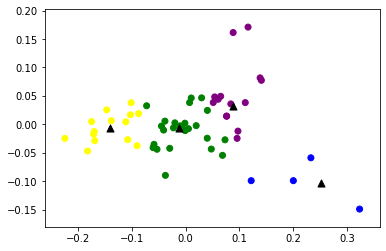

In [5]:
kmeans_model = KMeans(n_clusters=4, init='k-means++', max_iter=100) 
X = kmeans_model.fit(d2v_model.wv.syn0)
clusters=kmeans_model.labels_.tolist()
l = kmeans_model.fit_predict(d2v_model.wv.syn0)
pca = PCA(n_components=2).fit(d2v_model.wv.syn0)
datapoint = pca.transform(d2v_model.wv.syn0)

import matplotlib.pyplot as plt

%matplotlib inline
plt.figure
label1 = ['#FFFF00', '#008000', '#0000FF', '#800080']
color = [label1[i] for i in clusters]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)
centroids = kmeans_model.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=50, c='#000000')
plt.show()

In [12]:
# cluster our tokenized sentences into 10 groups
kMeansCluster = KMeans(n_clusters=4)
kMeansCluster.fit(d2v_model.wv.syn0)
clusters = kMeansCluster.labels_.tolist()

/home/ifte/amiebot_project/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
len(clusters)
sentences
len(d2v_model.wv.syn0)
#list(enumerate(sentences))

/home/ifte/amiebot_project/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  This is separate from the ipykernel package so we can avoid doing imports until


57

In [6]:
####################################
# Organize Cluster Results
####################################

# Create new dictionary that tracks which cluster each sentence belongs to
# keeps copy of original sentences and stemmed sentences
# sentenceDictionary { idx: { text: String, stemmed: String, cluster: Number } }
sentenceDictionary = {}
for idx, sentence in enumerate(sentences):
	sentenceDictionary[idx] = {}
	sentenceDictionary[idx]['text'] = sentence
	sentenceDictionary[idx]['cluster'] = clusters[idx]
	sentenceDictionary[idx]['stemmed'] = processedSentences[idx]

# Create new dictionary that contains 1 entry for each cluster
# each key in dictionary will point to array of sentences, all of which belong to that cluster
# we attach the index to the sentenceDictionary object so we can recall the original sentence
clusterDictionary = {}
for key, sentence in sentenceDictionary.items():
	if sentence['cluster'] not in clusterDictionary:
		clusterDictionary[sentence['cluster']] = []
	clusterDictionary[sentence['cluster']].append(sentence['stemmed'])
	sentence['idx'] = len(clusterDictionary[sentence['cluster']]) - 1


vectorizer = TfidfVectorizer()

####################################
# Calculate Cosine Similarity Scores
####################################		

# For each cluster of sentences,
# Find the sentence with highet cosine similarity over all sentences in cluster
maxCosineScores = {}
for key, clusterSentences in clusterDictionary.items():
	maxCosineScores[key] = {}
	maxCosineScores[key]['score'] = 0
	tfidf_matrix = vectorizer.fit_transform(clusterSentences)
	cos_sim_matrix = cosine_similarity(tfidf_matrix)
    
	for idx, row in enumerate(cos_sim_matrix):
		sum = 0
		for col in row:
			sum += col
		if sum > maxCosineScores[key]['score']:
			maxCosineScores[key]['score'] = sum
			maxCosineScores[key]['idx'] = idx


####################################
# Construct Document Summary
####################################	

# for every cluster's max cosine score,
# find the corresponding original sentence
resultIndices = []
i = 0
for key, value in maxCosineScores.items():
	cluster = key
	idx = value['idx']
	stemmedSentence = clusterDictionary[cluster][idx]
	# key corresponds to the sentences index of the original document
	# we will use this key to sort our results in order of original document
	for key, value in sentenceDictionary.items():
		if value['cluster'] == cluster and value['idx'] == idx:
			resultIndices.append(key)

resultIndices.sort()

# Iterate over sentences and construct summary output
result = ''
for idx in resultIndices:
	result += sentences[idx] + ' '
		

print(result)

IndexError: list index out of range

In [16]:
clusters
len(clusters)

57